In [8]:
from desc import set_device
set_device("gpu")

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

from desc.continuation import solve_continuation_automatic
from desc.backend import jnp, functools, jit
from desc.examples import get
import desc.io
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid, QuadratureGrid
from desc.equilibrium.coords import get_rtz_grid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
    EffectiveRadius,
    ParallelConnectionLength,
    QuasisymmetryTwoTerm,
)
from desc.optimize import Optimizer
from desc.plotting import (
    plot_comparison,
    plot_section,
    plot_surfaces,
    plot_boundaries,
    plot_boozer_surface,
    plot_boozer_surface,
    plot_boundary,
    plot_qs_error,
)

## Methods ##

In [10]:
# Function to get value of a parameter directly
def get_value(eq, name, grid):
    return eq.compute(name, grid=grid)[name]


# Function to get the straight field line coordinate system, need iota for jit
# @functools.partial(jit, static_argnames=["rho","alpha","n_pol","n_points"])
def get_field_line_grid(eq, iota, rho=0.5, alpha=0, n_pol=4, n_points=200):
    n_tor = n_pol / (iota * eq.NFP)
    good_grid = get_rtz_grid(
        eq,
        jnp.array(rho),
        # np.array(rho),
        jnp.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        jnp.linspace(0, 2 * n_tor * jnp.pi, n_points * n_pol),
        coordinates="raz",
        iota=iota,
        period=(jnp.inf, 2 * jnp.pi, jnp.inf),
    )
    return good_grid

In [11]:
def run_step(k, eq, n_wells = 5, maxiter=3):
    """Run a step of the precise QA optimization example from Landreman & Paul."""

    # create grid where we want to minimize QS error. Here we do it on 3 surfaces
    # grid = get_field_line_grid(eq,n_pol=10)

    # create grid where we want to minimize QS error. Here we do it on 3 surfaces
    grid = LinearGrid(
        M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=jnp.array([0.6, 0.8, 1.0]), sym=True
    )

    # we create an ObjectiveFunction, in this case made up of multiple objectives
    # which will be combined in a least squares sense
    objective = ObjectiveFunction(
        (
            QuasisymmetryTwoTerm(eq=eq, helicity=(1, 0), grid=grid),
            EffectiveRadius(eq=eq, n_wells=n_wells, n_pol=15),
            # AspectRatio(eq=eq, target=6),
            # ParallelConnectionLength(eq=eq,n_wells=4,target_type=target_type,n_pol=10,target=2*jnp.ones(4)),
        ),
    )
    # as opposed to SIMSOPT and STELLOPT where variables are assumed fixed, in DESC
    # we assume variables are free. Here we decide which ones to fix, starting with
    # the major radius (R mode = [0,0,0]) and all modes with m,n > k
    R_modes = jnp.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                jnp.max(jnp.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[
        jnp.max(jnp.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]
    # next we create the constraints, using the mode number arrays just created
    # if we didn't pass those in, it would fix all the modes (like for the profiles)
    constraints = (
        ForceBalance(eq=eq),
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        FixPressure(eq=eq),
        FixCurrent(eq=eq),
        FixPsi(eq=eq),
    )
    # this is the default optimizer, which re-solves the equilibrium at each step
    optimizer = Optimizer("proximal-lsq-exact")

    eq_new, history = eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=maxiter,  # we don't need to solve to optimality at each multigrid step
        verbose=3,
        copy=True,  # don't modify original, return a new optimized copy
        options={
            # Sometimes the default initial trust radius is too big, allowing the
            # optimizer to take too large a step in a bad direction. If this happens,
            # we can manually specify a smaller starting radius. Each optimizer has a
            # number of different options that can be used to tune the performance.
            # See the documentation for more info.
            "initial_trust_ratio": 1.0,
        },
    )

    return eq_new

In [12]:
def run_step_weights(k, eq, maxiter=3, qs_weight=1.0, aspect_ratio_weight=1.0, n_wells=5, n_pol=11):
    """
    Run a step of the precise QH optimization example from Landreman & Paul with weights.

    Parameters:
    - k: Threshold for the modes to fix.
    - eq: Initial DESC equilibrium object.
    - maxiter: Maximum number of iterations for the optimization.
    - method: Optimization method for DESC.
    - target_type: Target type for effective radius optimization.
    - qs_weight: Weight for the quasisymmetry term.
    - aspect_ratio_weight: Weight for the aspect ratio term.
    - n_wells: Number of wells for effective radius optimization.
    - n_pol: Number of poloidal turns.

    Returns:
    - eq_new: Optimized equilibrium object.
    """
    # Create grid for minimizing quasisymmetry error
    grid = LinearGrid(
        M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=jnp.array([0.6, 0.8, 1.0]), sym=True
    )

    # Create an ObjectiveFunction with weights
    objective = ObjectiveFunction(
        (
            QuasisymmetryTwoTerm(eq=eq, helicity=(1, 0), grid=grid, weight=qs_weight),
            EffectiveRadius(eq=eq, n_wells=n_wells, n_pol=n_pol),
            AspectRatio(eq=eq, target=6, weight=aspect_ratio_weight),
            # ParallelConnectionLength(eq=eq,n_wells=4,target_type=target_type,n_pol=10,target=2*jnp.ones(4)),
        ),
    )
    
    # Fix modes according to the threshold
    R_modes = jnp.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                jnp.max(jnp.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[
        jnp.max(jnp.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]

    # Create constraints
    constraints = (
        ForceBalance(eq=eq),
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        FixPressure(eq=eq),
        FixCurrent(eq=eq),
        FixPsi(eq=eq),
    )

    # Default optimizer
    optimizer = Optimizer("proximal-lsq-exact")

    # Optimize equilibrium
    eq_new, history = eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=maxiter,
        verbose=3,
        copy=True,
        options={
            "initial_trust_ratio": 1.0,
        },
    )

    return eq_new

In [13]:
def plot_Kd(eq, n_pol=16, rho=0.5, n_wells=5):
    iota_grid = LinearGrid(rho=rho)
    iota = jnp.abs(eq.compute("iota", iota_grid)["iota"][0])
    grid = get_field_line_grid(eq, iota, n_pol=n_pol, rho=rho)
    Kd = get_value(eq, "Kd", grid)
    plt.figure()
    plt.plot(grid.nodes[:, 2], Kd)
    plt.axhline(0, color="r", linestyle="--")
    plt.xlabel(r"$\zeta$")
    plt.ylabel(r"$K_d$")
    R_eff = eq.compute("R_eff", grid=grid, n_wells=n_wells)["R_eff"]
    L_par = eq.compute("L_par", grid=grid, n_wells=n_wells)["L_par"]
    a = get_value(eq, "a", grid)

    # Format the text to be displayed in the box
    textstr = (
        f"Mean value of $a/R_{{eff}}$: {a/R_eff.mean():.3f}\n"
        f"Mean value of $a/L_{{par}}$: {a/L_par.mean():.3f}\n"
        f"Minimum value of $a/R_{{eff}}$: {a/R_eff.max():.3f}\n"
        f"Minimum value of $a/L_{{par}}$: {a/L_par.max():.3f}\n"
    )

    # Add the text box to the plot
    props = dict(boxstyle="round", facecolor="white", alpha=0.5)
    plt.text(
        0.05,
        0.95,
        textstr,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=props,
    )

    # Add a legend and show the plot
    # plt.legend()
    plt.show()

    # Print the values for verification
    # print(f"Values of R_eff are: {R_eff}")
    # print(f"Values of L_par are: {L_par}")
    return grid, R_eff, L_par

In [15]:
def check_force_error(eq):
    grid = QuadratureGrid(eq.L_grid, eq.M_grid, eq.N_grid, eq.NFP)
    data = eq.compute(["p", "sqrt(g)", "|F|", "|grad(|B|^2)|/2mu0"], grid)
    err = jnp.sum(data["|F|"] * data["sqrt(g)"] * grid.weights) / jnp.sum(
        data["|grad(|B|^2)|/2mu0"] * data["sqrt(g)"] * grid.weights
    )
    print("eq error: {:.2f}%".format(err * 1e2))

## Testing ##

### Initialization ###

In [16]:
eq = get("precise_QA")

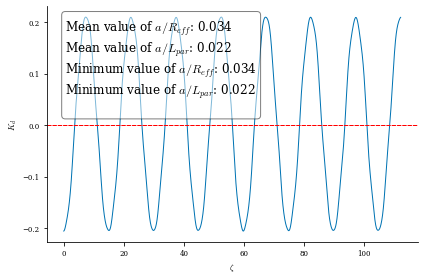

In [17]:
_, R_eff, L_par = plot_Kd(eq, n_pol=15);

In [18]:
print(f"R_eff : {R_eff}")
print(f"L_par : {L_par}")

R_eff : [4.94640446 4.99568358 4.95426706 4.91144081 4.93285525]
L_par : [7.70638155 7.55674307 7.51933345 7.40710459 7.33228535]


### Check influence of number of wells ###

In [11]:
def run_well_optimizations(eq,n_wells_array):
    eqfam = EquilibriaFamily(eq)
    for n_wells in n_wells_array:
        eq_test = eq.copy()
        try:
            eq_new = run_step(1, eq_test, n_wells=n_wells)
            eqfam.append(eq_new)
            print(f"Optimization successful for n_wells={n_wells}")
        except Exception as e:
            print(f"Optimization failed for n_wells={n_wells}: {e}")
    return eqfam
        

In [ ]:
n_wells_array = [2,3,5,8,10,12]
eqfam = run_well_optimizations(eq,n_wells_array)

It would seem that the best choice (strongest improvement) is for a number of wells around half of the present number of wells

### Check influence of QS and Aspect ratio weights ###

In [23]:
def generate_weights(num_weights=4, min_weight=1, max_weight=100):
    """
    Generate logarithmically spaced weights for optimization parameters between min_weight and max_weight.

    Parameters:
    - num_weights: Number of weights to generate for each parameter.
    - min_weight: Minimum weight value.
    - max_weight: Maximum weight value.

    Returns:
    - A list of tuples (qs_weight, aspect_ratio_weight) with all combinations of weights.
    """
    # Generate weights in log space between min_weight and max_weight
    qs_weights = jnp.logspace(jnp.log10(min_weight), jnp.log10(max_weight), num=num_weights)
    aspect_ratio_weights = jnp.logspace(jnp.log10(min_weight), jnp.log10(max_weight), num=num_weights)
    
    # Create all combinations of the weights
    weight_combinations = [(qs, ar) for qs in qs_weights for ar in aspect_ratio_weights]
    return weight_combinations

def run_all_experiments(eq, weight_combinations, maxiter=3):
    """
    Run a series of optimizations for each weight combination and store results.

    Parameters:
    - eq: Initial DESC equilibrium object.
    - weight_combinations: List of (qs_weight, aspect_ratio_weight) tuples.
    - maxiter: Maximum number of iterations for each optimization.
    - method: Optimization method for DESC.
    - target_type: Target type for effective radius optimization.

    Returns:
    - eqfam: EquilibriaFamily containing optimized equilibrium objects.
    - results_df: Pandas DataFrame containing the weight values for each run.
    """
    eqfam = EquilibriaFamily(eq)  # Initialize with initial equilibrium
    results = []  # List to store weight values for each experiment
    
    for qs_weight, ar_weight in weight_combinations:
        eq_test = eq.copy()
        try:
            # Run optimization for each weight combination
            eq_new = run_step_weights(
                k=1, 
                eq=eq_test, 
                maxiter=maxiter, 
                qs_weight=qs_weight, 
                aspect_ratio_weight=ar_weight,
                n_wells=5, 
                n_pol=8
            )
            # Append the new equilibrium to the family
            eqfam.append(eq_new)
            # Log the weight values
            results.append({'qs_weight': qs_weight, 'aspect_ratio_weight': ar_weight, 'status': 'Success'})
            print(f"Optimization successful for qs_weight={qs_weight}, ar_weight={ar_weight}")
        except Exception as e:
            print(f"Optimization failed for qs_weight={qs_weight}, ar_weight={ar_weight}: {e}")
            results.append({'qs_weight': qs_weight, 'aspect_ratio_weight': ar_weight, 'status': 'Failed'})
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return eqfam, results_df


In [28]:
# Generate the weight combinations and run experiments
weight_combinations = generate_weights(num_weights=4)
eqfam, results_df = run_all_experiments(eq, weight_combinations)

# # Display the results
print(results_df)


/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 839 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 201 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 43.6 ms
Timer: Objective build = 1.89 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 729 ms
Timer: Objective build = 804 ms
Timer: Proximal projection build = 10.7 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 645 ms
Timer: Linear constraint projection build = 3.18 sec
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 14.6 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0             

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 75.1 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 183 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 42.4 ms
Timer: Objective build = 240 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 81.4 ms
Timer: Objective build = 96.7 ms
Timer: Proximal projection build = 1.50 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 123 ms
Timer: Linear constraint projection build = 325 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.03 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 79.3 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 196 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 47.2 ms
Timer: Objective build = 255 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 86.5 ms
Timer: Objective build = 103 ms
Timer: Proximal projection build = 1.58 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 127 ms
Timer: Linear constraint projection build = 355 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.16 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 78.9 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 220 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 44.6 ms
Timer: Objective build = 252 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 90.7 ms
Timer: Objective build = 110 ms
Timer: Proximal projection build = 1.55 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 125 ms
Timer: Linear constraint projection build = 340 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.12 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 78.6 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 159 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 40.2 ms
Timer: Objective build = 236 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 85.1 ms
Timer: Objective build = 101 ms
Timer: Proximal projection build = 1.50 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 137 ms
Timer: Linear constraint projection build = 333 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.06 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 81.8 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 273 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 45.3 ms
Timer: Objective build = 255 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 91.4 ms
Timer: Objective build = 109 ms
Timer: Proximal projection build = 1.55 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 128 ms
Timer: Linear constraint projection build = 341 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.10 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 78.0 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 260 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 43.3 ms
Timer: Objective build = 245 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 86.5 ms
Timer: Objective build = 103 ms
Timer: Proximal projection build = 1.51 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 127 ms
Timer: Linear constraint projection build = 338 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.07 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 85.5 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 286 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 47.6 ms
Timer: Objective build = 267 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 93.8 ms
Timer: Objective build = 111 ms
Timer: Proximal projection build = 1.57 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 135 ms
Timer: Linear constraint projection build = 355 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.16 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 89.5 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 250 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 49.8 ms
Timer: Objective build = 278 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 100 ms
Timer: Objective build = 119 ms
Timer: Proximal projection build = 1.70 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 135 ms
Timer: Linear constraint projection build = 348 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.28 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1 

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 84.3 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 332 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 45.8 ms
Timer: Objective build = 263 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 89.7 ms
Timer: Objective build = 109 ms
Timer: Proximal projection build = 1.65 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 139 ms
Timer: Linear constraint projection build = 371 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.26 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 78.5 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 224 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 42.0 ms
Timer: Objective build = 243 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 84.3 ms
Timer: Objective build = 100 ms
Timer: Proximal projection build = 1.50 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 122 ms
Timer: Linear constraint projection build = 359 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.08 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 78.0 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 246 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 42.8 ms
Timer: Objective build = 244 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 84.8 ms
Timer: Objective build = 101 ms
Timer: Proximal projection build = 1.49 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 122 ms
Timer: Linear constraint projection build = 322 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.02 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 77.2 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 237 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 39.8 ms
Timer: Objective build = 234 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 78.6 ms
Timer: Objective build = 93.9 ms
Timer: Proximal projection build = 1.45 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 122 ms
Timer: Linear constraint projection build = 324 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 1.98 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 76.3 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 237 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 41.5 ms
Timer: Objective build = 236 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 78.9 ms
Timer: Objective build = 94.0 ms
Timer: Proximal projection build = 1.54 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 125 ms
Timer: Linear constraint projection build = 362 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 2.12 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 77.8 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 240 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 40.3 ms
Timer: Objective build = 239 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 81.0 ms
Timer: Objective build = 97.7 ms
Timer: Proximal projection build = 1.46 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 122 ms
Timer: Linear constraint projection build = 320 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 1.99 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              

/tmp/ipykernel_737316/2994765076.py:35: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 76.4 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 279 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 39.8 ms
Timer: Objective build = 238 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 78.8 ms
Timer: Objective build = 93.7 ms
Timer: Proximal projection build = 1.45 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 122 ms
Timer: Linear constraint projection build = 320 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 1.98 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              

## Data analysis ##

In [36]:
import matplotlib.pyplot as plt

def plot_Kd_family(eqfam, results_df, n_pol=16, rho=0.5, n_wells=5):
    """
    Plot Kd for each equilibrium in the family in a 4x4 grid.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    - n_pol: Number of poloidal turns for the Kd calculation.
    - rho: Radius in normalized coordinates.
    - n_wells: Number of wells for effective radius optimization.
    """
    # Create a new figure
    fig, axs = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle("Kd Plots for Optimized Equilibria", fontsize=16)

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs.flatten())):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]['qs_weight']
            aspect_ratio_weight = results_df.iloc[i]['aspect_ratio_weight']
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Calculate and plot Kd
            iota_grid = LinearGrid(rho=rho)
            iota = jnp.abs(eq.compute("iota", iota_grid)["iota"][0])
            grid = get_field_line_grid(eq, iota, n_pol=n_pol, rho=rho)
            Kd = get_value(eq, "Kd", grid)
            ax.plot(grid.nodes[:, 2], Kd)
            ax.axhline(0, color="r", linestyle="--")
            ax.set_xlabel(r"$\zeta$")
            ax.set_ylabel(r"$K_d$")
            
            # Calculate R_eff and L_par for displaying in the text box
            R_eff = eq.compute("R_eff", grid=grid, n_wells=n_wells)["R_eff"]
            L_par = eq.compute("L_par", grid=grid, n_wells=n_wells)["L_par"]
            a = get_value(eq, "a", grid)

            # Format the text to be displayed in the box
            textstr = (
                f"Mean $a/R_{{eff}}$: {a/R_eff.mean():.3f}\n"
                f"Mean $a/L_{{par}}$: {a/L_par.mean():.3f}\n"
                f"Min $a/R_{{eff}}$: {a/R_eff.max():.3f}\n"
                f"Min $a/L_{{par}}$: {a/L_par.max():.3f}\n"
            )

            # Add the text box to the plot
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )
        else:
            ax.axis('off')  # Turn off axes if there are more subplots than equilibria

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()

# Example usage



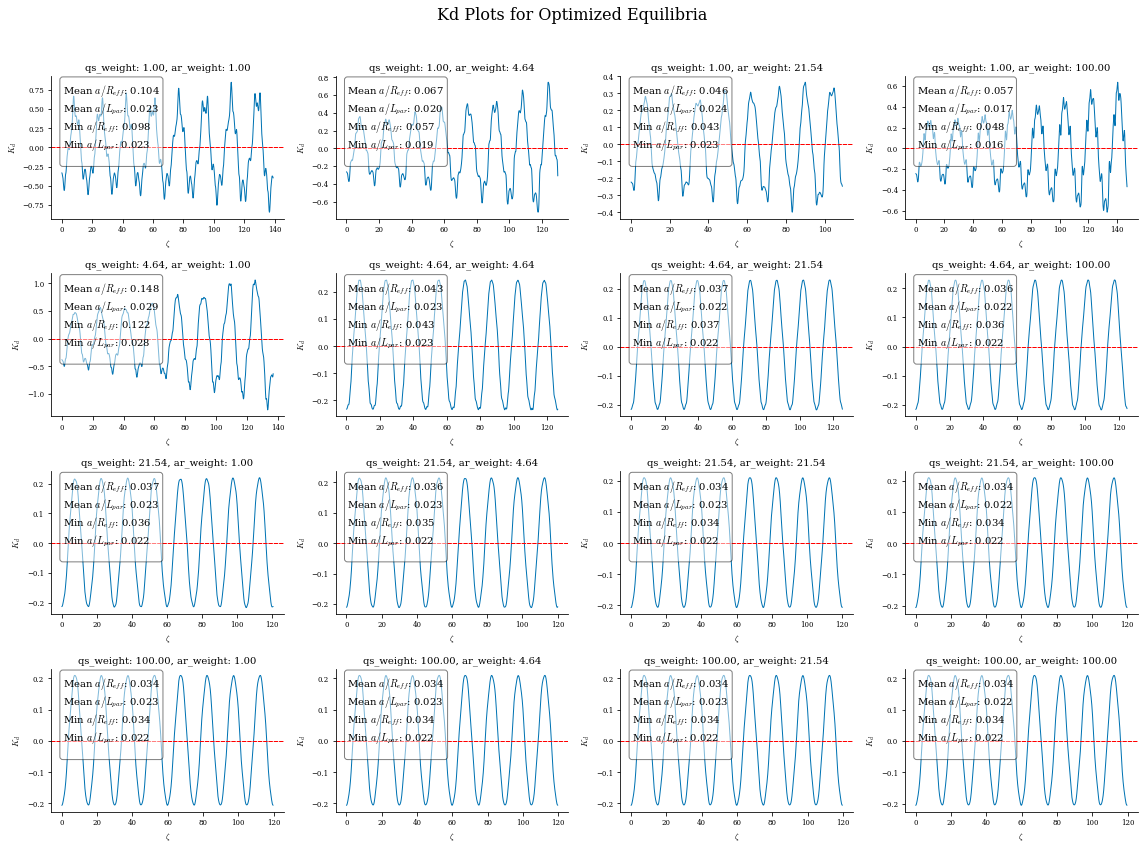

In [37]:
# Example usage
plot_Kd_family(eqfam, results_df)

In [38]:
import matplotlib.pyplot as plt

def plot_quasisymmetry_family(eqfam, results_df, rho=0.5, fill=False, ncontours=30, fieldlines=0):
    """
    Plot quasisymmetry for each equilibrium in the family in a 4x4 grid.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    - rho: Radius in normalized coordinates.
    - fill: Whether the contours are filled, i.e. whether to use `contourf` or `contour`.
    - ncontours: Number of contours to plot.
    - fieldlines: Number of (linearly spaced) magnetic fieldlines to plot. Default is 0 (none).
    """
    # Create a new figure
    fig, axs = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle("Quasisymmetry Plots for Optimized Equilibria", fontsize=16)

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs.flatten())):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]['qs_weight']
            aspect_ratio_weight = results_df.iloc[i]['aspect_ratio_weight']
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Plot Boozer surface for the current equilibrium
            plot_boozer_surface(
                eq,
                rho=rho,
                fill=fill,
                ncontours=ncontours,
                fieldlines=fieldlines,
                ax=ax
            )
            
            # Customize the plot axes
            ax.axhline(0, color="r", linestyle="--")

            # Optionally, you can add additional calculated values to the text box
            textstr = (
                f"qs_weight: {qs_weight:.2f}\n"
                f"ar_weight: {aspect_ratio_weight:.2f}\n"
            )

            # Add the text box to the plot
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )
        else:
            ax.axis('off')  # Turn off axes if there are more subplots than equilibria

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()

# Example usage



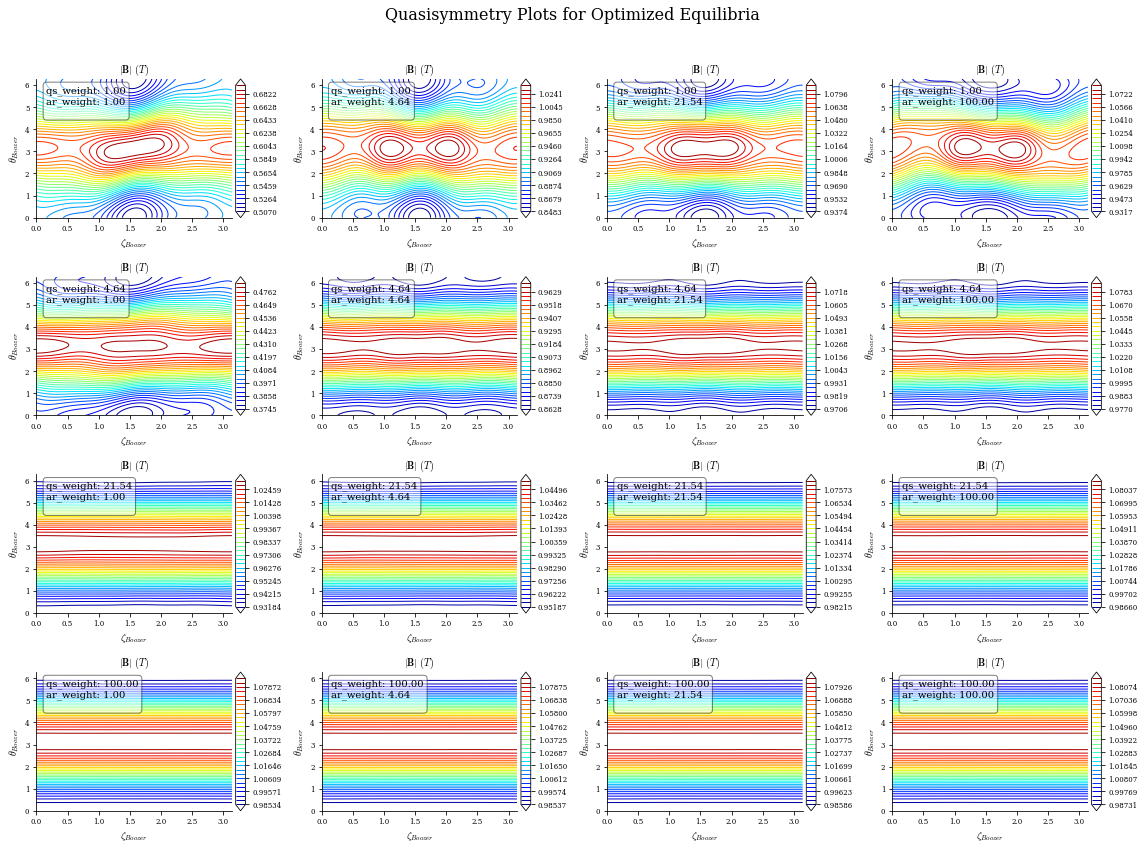

In [39]:
plot_quasisymmetry_family(eqfam, results_df)

In [42]:
import matplotlib.pyplot as plt

def plot_quasisymmetry_family(eqfam, results_df, rho=0.5, fill=False, ncontours=30, fieldlines=0):
    """
    Plot quasisymmetry for each equilibrium in the family in a 4x4 grid.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    - rho: Radius in normalized coordinates.
    - fill: Whether the contours are filled, i.e. whether to use `contourf` or `contour`.
    - ncontours: Number of contours to plot.
    - fieldlines: Number of (linearly spaced) magnetic fieldlines to plot. Default is 0 (none).
    """
    # Create a new figure
    eq_initial = eqfam[0]
    fig, axs = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle("Quasisymmetry Plots for Optimized Equilibria", fontsize=16)

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs.flatten())):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]['qs_weight']
            aspect_ratio_weight = results_df.iloc[i]['aspect_ratio_weight']
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Plot boundaries for the current equilibrium
            plot_boundaries(
                eqs=[eq_initial, eq],
                labels=[
                    "Before optimization",
                    "After optimization",
                ],
                ax=ax
            )
            
            # Customize the plot axes
            ax.axhline(0, color="r", linestyle="--")

            # Add the text box to the plot
            textstr = (
                f"qs_weight: {qs_weight:.2f}\n"
                f"ar_weight: {aspect_ratio_weight:.2f}\n"
            )

            # Create a text box with the weight information
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )
        else:
            ax.axis('off')  # Turn off axes if there are more subplots than equilibria

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()

# Example usage



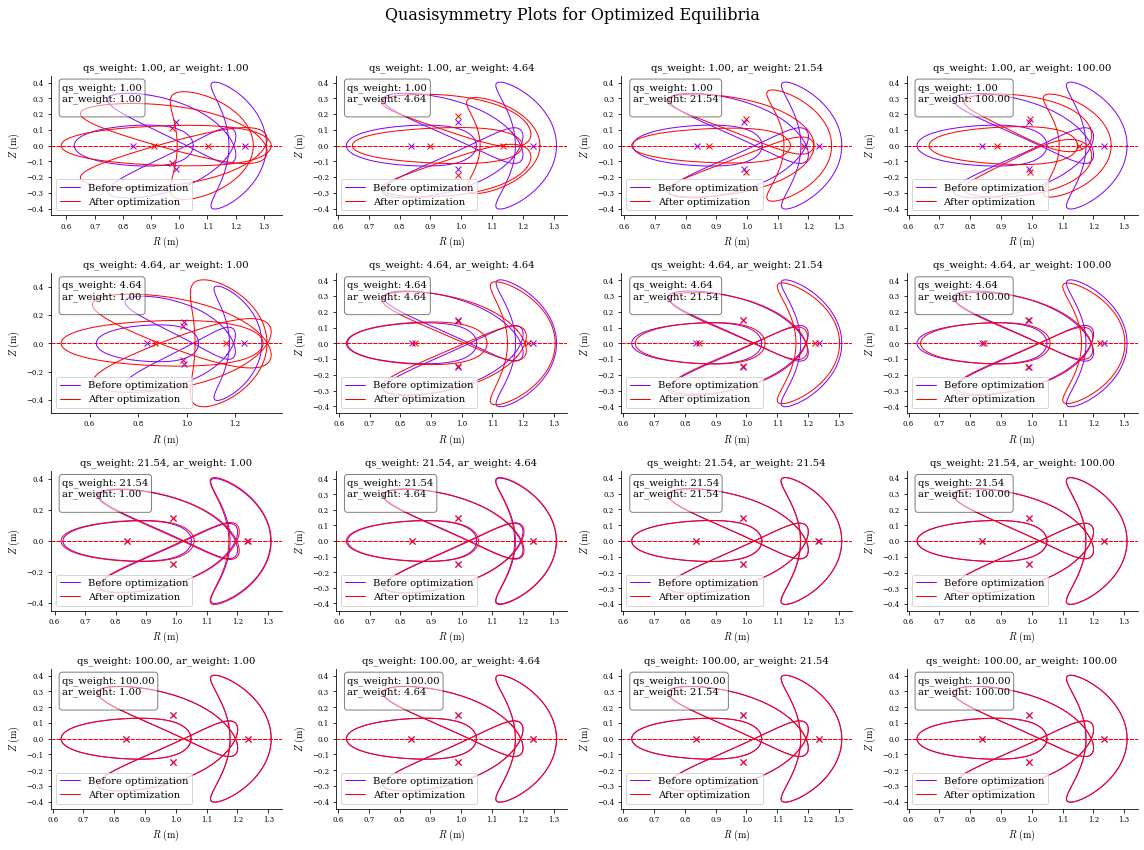

In [43]:
plot_quasisymmetry_family(eqfam, results_df)

In [46]:
import matplotlib.pyplot as plt

def plot_quasisymmetry_error_family(eqfam, results_df):
    """
    Plot quasisymmetry error for each equilibrium in the family in a 4x4 grid.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    """
    # Create a new figure
    fig, axs = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle("Quasisymmetry Error for Optimized Equilibria", fontsize=16)

    eq_initial = eqfam[0]

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs.flatten())):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]['qs_weight']
            aspect_ratio_weight = results_df.iloc[i]['aspect_ratio_weight']
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Plot QS error for eq_initial and the current equilibrium
            fig_qs_error, ax = plot_qs_error(
                eq_initial, helicity=(1, 0), fT=True, fC=True, legend=False, rho=10, ax=ax
            )
            plot_qs_error(
                eq, helicity=(1, 0), fT=True, fC=True, ax=ax, marker=["x"], rho=10
            )
            
            # Add the weight information in a text box
            textstr = (
                f"qs_weight: {qs_weight:.2f}\n"
                f"ar_weight: {aspect_ratio_weight:.2f}\n"
            )

            # Create a text box with the weight information
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )
        else:
            ax.axis('off')  # Turn off axes if there are more subplots than equilibria

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()

# Example usage



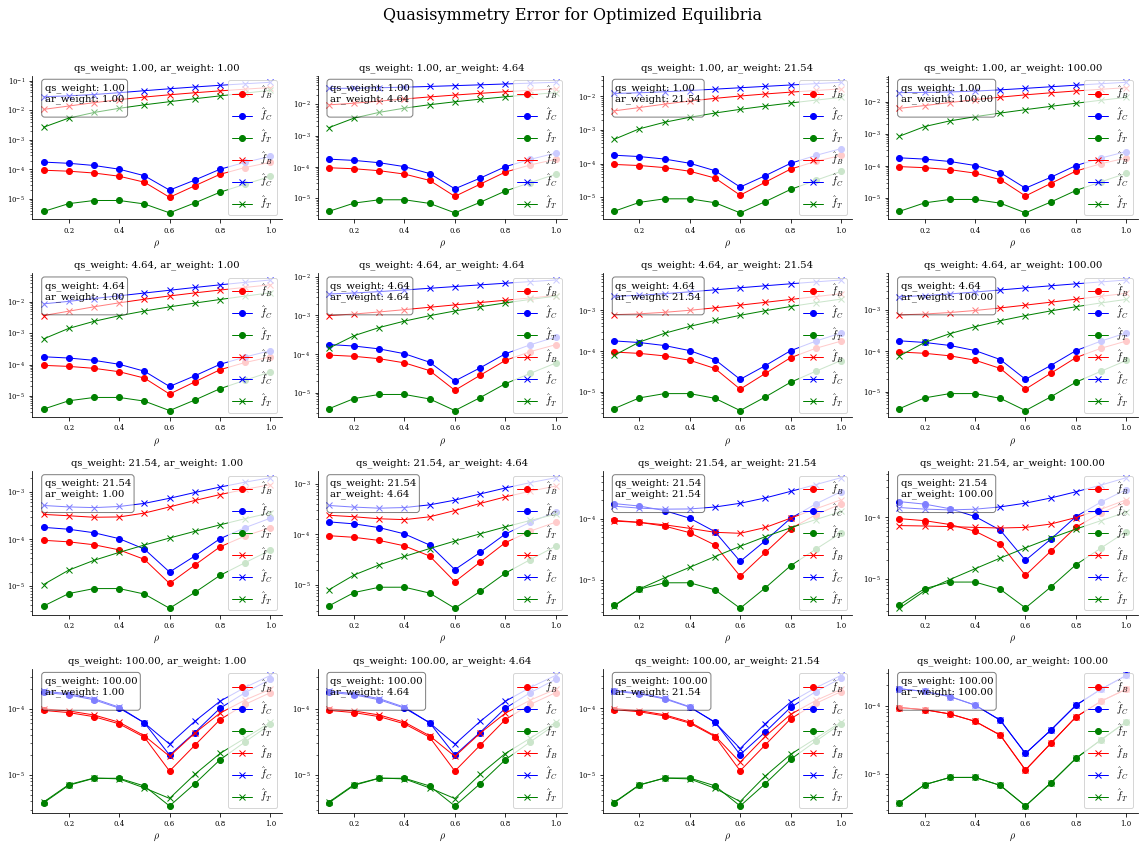

In [47]:
plot_quasisymmetry_error_family(eqfam, results_df)